In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import scipy
import datetime

In [3]:
aust_yld_crv =  [
                (datetime.date(2022,9,20),-0.73),
                (datetime.date(2023,7,15),-0.745),
                (datetime.date(2024,7,15),-0.731),
                (datetime.date(2025,10,20),-0.715),
                (datetime.date(2026,10,20),-0.635),
                (datetime.date(2027,4,20),-0.600),
                (datetime.date(2028,2,20),-0.516),
                (datetime.date(2029,2,20),-0.403),
                (datetime.date(2030,2,20),-0.319),
                (datetime.date(2031,2,20),-0.234),
                (datetime.date(2037,3,15),0.026),
                (datetime.date(2040,10,20),0.222),
                (datetime.date(2047,2,20),0.295),
                (datetime.date(2051,3,20),0.36065),
                (datetime.date(2062,1,26),0.466),
                (datetime.date(2086,11,2),0.655),
                (datetime.date(2120,6,30),0.806103),
                ]

In [4]:
class Bond():
    def __init__(self, acc, mat, cpn, yld, c_dt=datetime.date(2021, 8, 6)):
        '''
        acc = first interest accrual date
        mat = maturity date
        cpn = coupon in percent

        c_dt = current date
        yld = yield in percent
        '''
        self.acc = acc
        self.mat = mat
        self.cpn = cpn
        self.tenor = mat.year - acc.year
        self.cpn_dates = self.get_cpn_dates()
        self.yld = yld
        self.c_dt = c_dt

    def get_cpn_dates(self):
        '''
        Output: list of cpn payment dates using first accrual, assume Act/Act Annual
        '''
        return [datetime.date(self.acc.year + i + 1, self.acc.month, self.acc.day) for i in range(self.tenor)]

    def get_discount_factors(self):
        '''
        Output: list of discount factors from cpn_dates, assuming flat yield
        '''
        val_cpn_dates = [i for i in self.cpn_dates if i > self.c_dt]
        year_frac = [(i - self.c_dt).days / 365. for i in val_cpn_dates]
        discount_rates = [self.yld / 100.] * len(val_cpn_dates)
        return [1 / ((1 + discount_rates[i]) ** year_frac[i]) for i in range(len(year_frac))]

    def dirty_px(self):
        '''
        Inputs: c_dt, maturity, cpn, yld
        Output: dirty price
        '''
        disc_fact = self.get_discount_factors()
        return sum([d * self.cpn for d in disc_fact]) + (100 * disc_fact[-1])

    def clean_px(self):
        '''
        Inputs: c_dt, maturity, cpn, yld
        Output: dirty price
        '''
        next_year_frac = ([i for i in self.cpn_dates if i > self.c_dt][0] - self.c_dt).days / 365.
        next_disc_fact = self.get_discount_factors()[0]
        dirty_px = self.dirty_px()
        return dirty_px - (1 - next_year_frac) * next_disc_fact * self.cpn

    def dv01(self):
        '''
        Inputs: c_dt, maturity, cpn, yld
        Output: dv01

        val_cpn_dates = [i for i in self.cpn_dates if i > self.c_dt]
        w = 1-(val_cpn_dates[0] - self.c_dt).days/365.
        y = self.yld/100.
        C = self.cpn/100.
        N = float(len(val_cpn_dates))
        P = self.dirty_px()/100.
        return -1*(((1+y)**w)*((C/(y**2))*((1/((1+y)**N))-1) + N*((C/y) -1)*(1/((1+y)**(N+1))))+(w/(1+y))*P)
        '''
        px_base = self.dirty_px()
        start_yld = self.yld
        self.yld = start_yld + 0.01
        px_up = self.dirty_px()
        self.yld = start_yld - 0.01
        px_down = self.dirty_px()
        self.yld = start_yld
        return 100 * (px_down - px_up) / 2.0

    def convexity(self):
        '''
        Inputs: c_dt, maturity, cpn, yld
        Output: convexity
        val_cpn_dates = [i for i in self.cpn_dates if i > self.c_dt]
        w = 1 - (val_cpn_dates[0] - self.c_dt).days / 365.
        y = self.yld / 100.
        C = self.cpn / 100.
        N = float(len(val_cpn_dates))
        P = self.dirty_px()
        t1 = (-w / ((1 + y) ** 2)) * P + (w / (1 + y)) * dv01
        t2 = (N * (N + 1 - w)) * ((1 - (C / y)) / ((1 + y) ** (N + 2 - w)))
        t3 = (2 * C * N / (y ** 2)) / ((1 + y) ** (N + 1 - w))
        t4 = C * (((1 + y) ** w) / (y ** 3)) * (1 - 1 / ((1 + y) ** N)) * (2 - ((w * y) / (1 + y)))
        return (t1 + t2 - t3 + t4)/100
        '''
        dv01_base = self.dv01()
        yld_base = self.yld
        self.yld = yld_base + 0.01
        dv01_up = self.dv01()
        self.yld = yld_base - 0.01
        dv01_down = self.dv01()
        self.yld = yld_base
        return 100 * abs(dv01_up - dv01_down) / 2.

    def mod_duration(self):
        '''
        Inputs: c_dt, maturity, cpn, yld
        Output: modified duration
        '''
        dv01 = self.dv01()
        dirty_px = self.dirty_px()
        return 100 * (1 / dirty_px) * dv01

In [36]:
def yld_scenarios(bd,yld_chg):
    '''
    bd: A bond object as defined above
    yld_chg: basis points to move yield up and down
    return: list of dirty pxs,dv01,dollar convexity
    '''
    start_yld = bd.yld
    yld_range = range(-yld_chg,yld_chg+1)
    prices = []
    dv01s = []
    convs = []
    for y in yld_range:
        bd.yld = start_yld+y/100
        prices.append(bd.dirty_px())
        dv01s.append(bd.dv01())
        convs.append(bd.convexity())
    return prices,dv01s,convs

def bond_scenarios(bd,t_chg,yld_chg,roll=False):
    '''
    :param bd: bond object
    :param t_chg: how many years forward
    :param y_ch: how many bp shocks
    :param roll: roll down the yield curve
    :return: 3 dataframes of prices,dv01s,convexities index by year, columns are yield shocks
    '''
    cols = range(-yld_chg,yld_chg+1)
    px_df = pd.DataFrame(columns=cols)
    dv_df = pd.DataFrame(columns=cols)
    conv_df = pd.DataFrame(columns=cols)
    start_yr = bd.c_dt.year
    start_yld = bd.yld
    for i in range(t_chg+1):
        bd.yld = start_yld
        eval_date = datetime.date(start_yr+i,bd.c_dt.month,bd.c_dt.day)
        if roll:
            xp = [datetime.date(j[0].year+i,j[0].month,j[0].day).toordinal() for j in aust_yld_crv]
            fp = [k[1] for k in aust_yld_crv]
            bd.yld = np.interp(bd.mat.toordinal(),xp,fp)
        bd.c_dt = datetime.date(start_yr+i,bd.c_dt.month,bd.c_dt.day)
        prices, dv01s, convs = yld_scenarios(bd,yld_chg)
        px_df.loc[eval_date] = prices
        dv_df.loc[eval_date] = dv01s
        conv_df.loc[eval_date] = convs
    return px_df,dv_df,conv_df

def flattener_scenarios(bd1,bd2):
    '''

    :param bd1: px,dv01,conv for bond1 - short this bond
    :param bd2: px,dv01,conv for bond2 - long this bond
    :return:
    '''

    scalar_1 = -100/bd1[1][0][0]
    scalar_2 = 100/bd2[1][0][0]

    px_df_30y, dv_df_30y, conv_df_30y = bd1[0]*scalar_1,bd1[1]*scalar_1,bd1[2]*scalar_1/100
    px_df_100y, dv_df_100y, conv_df_100y = bd2[0]*scalar_2,bd2[1]*scalar_2,bd2[2]*scalar_2/100
    pnl_30y = 100*(px_df_30y - px_df_30y[0][0])
    pnl_100y = 100*(px_df_100y - px_df_100y[0][0])
    total_pnl = pnl_30y+pnl_100y
    total_dv = dv_df_30y+dv_df_100y
    total_conv = conv_df_30y+conv_df_100y
    return  total_pnl,total_dv,total_conv

def x_intercept(total_df):
    '''
    find the x-intercept of incremental scenarios
    '''
    cols = list(total_df.index)
    input = 0
    intercepts = []
    for c in cols:
        df = total_df.T[c]
        df.iloc[(df-input).abs().argsort()[:2]]
        intercepts.append((c,sum(df.iloc[(df-input).abs().argsort()[:2]].index)/2.))
    return intercepts

def total_convexity_pnl(total_conv):
    convexity_pnl = pd.DataFrame(columns=total_conv.columns,index=total_conv.index)
    for c in convexity_pnl.columns:
        if c <0:
            convexity_pnl[c] = 0.5*total_conv[range(c,1)].sum(axis=1)
        else:
            convexity_pnl[c] = 0.5*total_conv[range(0,1)].sum(axis=1)
    return convexity_pnl

In [6]:
bond1 = Bond(datetime.date(2020,3,20),datetime.date(2051,3,20),0.75, 0.369605)
bond2 = Bond(datetime.date(2020,6,30),datetime.date(2120,6,30),0.85, 0.806103)

In [7]:
bond_sc1 = bond_scenarios(bond1,29,2000)
bond_sc2 = bond_scenarios(bond2,29,2000)

In [8]:
total_pnl,total_dv,total_conv = flattener_scenarios(bond_sc1,bond_sc2)

In [37]:
convexity_pnl = total_convexity_pnl(total_conv)

In [9]:
bond3 = Bond(datetime.date(2020,3,20),datetime.date(2051,3,20),0.75, 0.369605)
bond4 = Bond(datetime.date(2020,6,30),datetime.date(2120,6,30),0.85, 0.806103)

In [10]:
bond_sc3 = bond_scenarios(bond3,29,2000,True)
bond_sc4 = bond_scenarios(bond4,29,2000,True)

In [11]:
total_pnl_2,total_dv_2,total_conv_2 = flattener_scenarios(bond_sc3,bond_sc4)

In [40]:
convexity_pnl_2 = total_convexity_pnl(total_conv_2)

In [12]:
x_intercept(total_conv)

[(datetime.date(2021, 8, 6), 182.5),
 (datetime.date(2022, 8, 6), 190.5),
 (datetime.date(2023, 8, 6), 200.5),
 (datetime.date(2024, 8, 6), 209.5),
 (datetime.date(2025, 8, 6), 219.5),
 (datetime.date(2026, 8, 6), 229.5),
 (datetime.date(2027, 8, 6), 240.5),
 (datetime.date(2028, 8, 6), 252.5),
 (datetime.date(2029, 8, 6), 264.5),
 (datetime.date(2030, 8, 6), 277.5),
 (datetime.date(2031, 8, 6), 290.5),
 (datetime.date(2032, 8, 6), 305.5),
 (datetime.date(2033, 8, 6), 320.5),
 (datetime.date(2034, 8, 6), 337.5),
 (datetime.date(2035, 8, 6), 355.5),
 (datetime.date(2036, 8, 6), 374.5),
 (datetime.date(2037, 8, 6), 395.5),
 (datetime.date(2038, 8, 6), 418.5),
 (datetime.date(2039, 8, 6), 444.5),
 (datetime.date(2040, 8, 6), 472.5),
 (datetime.date(2041, 8, 6), 504.5),
 (datetime.date(2042, 8, 6), 540.5),
 (datetime.date(2043, 8, 6), 582.5),
 (datetime.date(2044, 8, 6), 633.5),
 (datetime.date(2045, 8, 6), 694.5),
 (datetime.date(2046, 8, 6), 771.5),
 (datetime.date(2047, 8, 6), 877.5),
 

In [13]:
x_intercept(total_conv_2)

[(datetime.date(2021, 8, 6), 182.5),
 (datetime.date(2022, 8, 6), 190.5),
 (datetime.date(2023, 8, 6), 199.5),
 (datetime.date(2024, 8, 6), 209.5),
 (datetime.date(2025, 8, 6), 218.5),
 (datetime.date(2026, 8, 6), 229.5),
 (datetime.date(2027, 8, 6), 240.5),
 (datetime.date(2028, 8, 6), 252.5),
 (datetime.date(2029, 8, 6), 264.5),
 (datetime.date(2030, 8, 6), 277.5),
 (datetime.date(2031, 8, 6), 291.5),
 (datetime.date(2032, 8, 6), 305.5),
 (datetime.date(2033, 8, 6), 320.5),
 (datetime.date(2034, 8, 6), 335.5),
 (datetime.date(2035, 8, 6), 352.5),
 (datetime.date(2036, 8, 6), 371.5),
 (datetime.date(2037, 8, 6), 392.5),
 (datetime.date(2038, 8, 6), 415.5),
 (datetime.date(2039, 8, 6), 441.5),
 (datetime.date(2040, 8, 6), 469.5),
 (datetime.date(2041, 8, 6), 502.5),
 (datetime.date(2042, 8, 6), 538.5),
 (datetime.date(2043, 8, 6), 579.5),
 (datetime.date(2044, 8, 6), 629.5),
 (datetime.date(2045, 8, 6), 690.5),
 (datetime.date(2046, 8, 6), 768.5),
 (datetime.date(2047, 8, 6), 875.5),
 

In [14]:
comp_conv = pd.DataFrame(columns=['Flat','Roll'])
comp_conv['Flat'] = total_conv[0]
comp_conv['Roll'] = total_conv_2[0]
comp_conv

,Flat,Roll
2021-08-06,0.563650,0.563611
2022-08-06,0.569480,0.571630
2023-08-06,0.574737,0.579172
2024-08-06,0.579432,0.586222
2025-08-06,0.583539,0.592742
2026-08-06,0.587069,0.598940
2027-08-06,0.590023,0.604540
2028-08-06,0.592404,0.609512
2029-08-06,0.594198,0.613836
2030-08-06,0.595412,0.617496


In [15]:
x_label = 'Yield Shift (bps)'
y_label = "PnL (€k)"

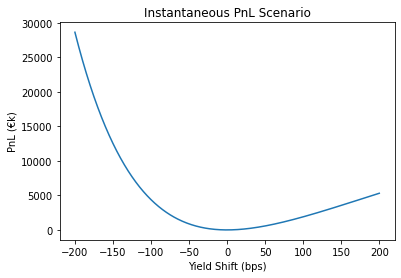

In [16]:
inst_pnl = plt.figure()
total_pnl[range(-200,201)].loc[datetime.date(2021,8,6)].T.plot()
plt.xlabel(x_label)
plt.ylabel(y_label)
plt.title('Instantaneous PnL Scenario')
inst_pnl.savefig('pnl_base.png',dpi=120,bbox_inches='tight')
plt.show()

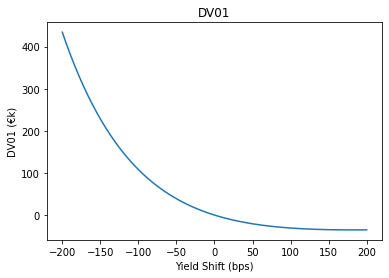

In [17]:
dv01 = plt.figure()
total_dv[range(-200,201)].loc[datetime.date(2021,8,6)].T.plot()
plt.xlabel(x_label)
plt.ylabel('DV01 (€k)' )
plt.title('DV01')
dv01.savefig('dv01.png',dpi=120,bbox_inches='tight')
plt.show()

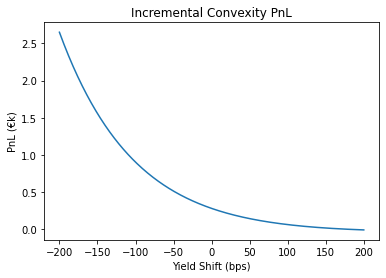

In [18]:
inc_conv = plt.figure()
(0.5*total_conv[range(-200,201)].loc[datetime.date(2021,8,6)].T).plot()
plt.xlabel(x_label)
plt.ylabel(y_label)
plt.title('Incremental Convexity PnL')
inc_conv.savefig('conv_base.png',dpi=120,bbox_inches='tight')
plt.show()

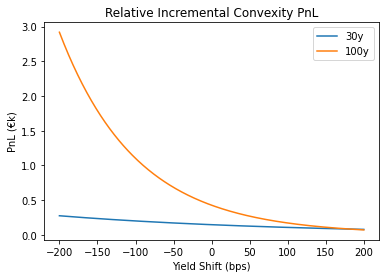

In [31]:
rel_conv = plt.figure()
((1/100)*3.38*0.5*bond_sc1[2][range(-200,201)].loc[datetime.date(2021,8,6)].T).plot(label='30y')
((1/100)*1.44*0.5*bond_sc2[2][range(-200,201)].loc[datetime.date(2021,8,6)].T).plot(label='100y')
plt.xlabel(x_label)
plt.ylabel(y_label)
plt.legend()
plt.title('Relative Incremental Convexity PnL')
rel_conv.savefig('rel_conv.png',dpi=120,bbox_inches='tight')
plt.show()

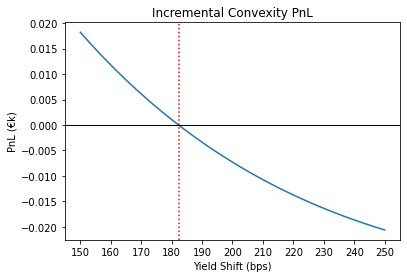

In [19]:
conv_cross = plt.figure()
(0.5*total_conv[range(150,251)].loc[datetime.date(2021,8,6)].T).plot()
plt.xlabel(x_label)
plt.ylabel(y_label)
plt.title('Incremental Convexity PnL')
plt.axvline(x=182.5,color='r',linestyle='dotted')
plt.axhline(y=0, color='black',linewidth=1)
conv_cross.savefig('conv_cross.png',dpi=120,bbox_inches='tight')
plt.xticks(np.arange(150,251,10))
plt.show()

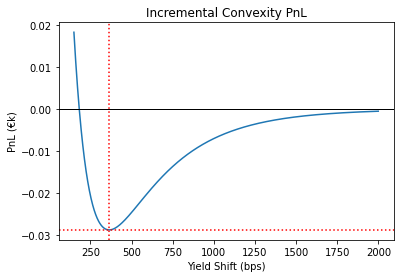

In [153]:
conv_cross_ext = plt.figure()
(0.5*total_conv[range(150,2000)].loc[datetime.date(2021,8,6)].T).plot()
plt.xlabel(x_label)
plt.ylabel(y_label)
plt.title('Incremental Convexity PnL')
plt.axvline(x=364,color='r',linestyle='dotted')
plt.axhline(y=0, color='black',linewidth=1)
plt.axhline(y=-0.028837, color='r',linestyle='dotted')
conv_cross_ext.savefig('conv_cross_ext.png',dpi=120,bbox_inches='tight')
plt.show()

<AxesSubplot:>

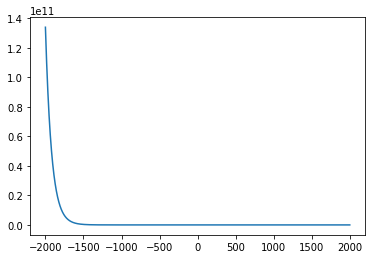

In [39]:
convexity_pnl.loc[datetime.date(2021,8,6)].T.plot()

<AxesSubplot:>

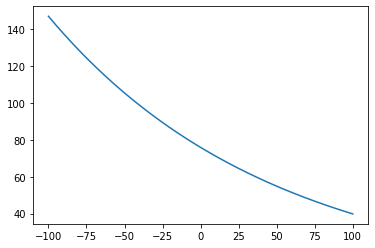

In [119]:
total_dv[range(-100,101)].loc[datetime.date(2050, 8, 6)].T.plot(legend=None)

In [125]:
total_conv.idxmin(axis=1)

2021-08-06     364
2022-08-06     377
2023-08-06     390
2024-08-06     404
2025-08-06     418
2026-08-06     433
2027-08-06     449
2028-08-06     466
2029-08-06     484
2030-08-06     503
2031-08-06     523
2032-08-06     545
2033-08-06     568
2034-08-06     593
2035-08-06     620
2036-08-06     649
2037-08-06     681
2038-08-06     716
2039-08-06     756
2040-08-06     800
2041-08-06     850
2042-08-06     908
2043-08-06     976
2044-08-06    1060
2045-08-06    1165
2046-08-06    1304
2047-08-06    1503
2048-08-06    1821
2049-08-06    2000
2050-08-06    2000
dtype: int64

In [126]:
total_conv_2.idxmin(axis=1)

2021-08-06     364
2022-08-06     377
2023-08-06     390
2024-08-06     403
2025-08-06     418
2026-08-06     433
2027-08-06     449
2028-08-06     466
2029-08-06     484
2030-08-06     504
2031-08-06     524
2032-08-06     545
2033-08-06     567
2034-08-06     590
2035-08-06     616
2036-08-06     645
2037-08-06     677
2038-08-06     712
2039-08-06     751
2040-08-06     795
2041-08-06     845
2042-08-06     902
2043-08-06     970
2044-08-06    1051
2045-08-06    1154
2046-08-06    1292
2047-08-06    1490
2048-08-06    1808
2049-08-06    2000
2050-08-06    2000
dtype: int64

In [140]:
total_pnl.min(axis=1)

2021-08-06       0.000000
2022-08-06     105.779452
2023-08-06     198.816277
2024-08-06     278.609113
2025-08-06     345.033804
2026-08-06     397.449466
2027-08-06     435.338822
2028-08-06     457.781521
2029-08-06     464.605578
2030-08-06     454.786570
2031-08-06     427.398658
2032-08-06     380.789774
2033-08-06     314.778804
2034-08-06     227.418476
2035-08-06     117.126737
2036-08-06     -18.867947
2037-08-06    -181.353659
2038-08-06    -373.736897
2039-08-06    -599.229845
2040-08-06    -862.884694
2041-08-06   -1167.396768
2042-08-06   -1519.797784
2043-08-06   -1927.763688
2044-08-06   -2403.083138
2045-08-06   -2956.060847
2046-08-06   -3607.527214
2047-08-06   -4386.481558
2048-08-06   -5344.453696
2049-08-06   -6570.601473
2050-08-06   -8343.357266
dtype: float64

In [141]:
total_dv[0]

2021-08-06     0.000000
2022-08-06     2.685949
2023-08-06     5.367635
2024-08-06     8.052349
2025-08-06    10.725295
2026-08-06    13.393740
2027-08-06    16.057604
2028-08-06    18.724125
2029-08-06    21.378605
2030-08-06    24.028258
2031-08-06    26.673001
2032-08-06    29.320018
2033-08-06    31.954713
2034-08-06    34.584245
2035-08-06    37.208530
2036-08-06    39.834689
2037-08-06    42.448240
2038-08-06    45.056283
2039-08-06    47.658729
2040-08-06    50.262638
2041-08-06    52.853645
2042-08-06    55.438787
2043-08-06    58.017973
2044-08-06    60.598195
2045-08-06    63.165214
2046-08-06    65.726001
2047-08-06    68.280463
2048-08-06    70.835517
2049-08-06    73.377062
2050-08-06    75.911996
Name: 0, dtype: float64

,0,1,2,3,4,5,6,7,8,9
2021-08-06,0.563650,0.556616,0.549656,0.542768,0.535952,0.529208,0.522535,0.515931,0.509396,0.502930
2022-08-06,0.569480,0.562553,0.555697,0.548912,0.542197,0.535552,0.528974,0.522465,0.516023,0.509647
2023-08-06,0.574737,0.567920,0.561172,0.554493,0.547882,0.541337,0.534860,0.528448,0.522101,0.515819
2024-08-06,0.579432,0.572728,0.566092,0.559521,0.553017,0.546577,0.540202,0.533891,0.527643,0.521458
2025-08-06,0.583539,0.576951,0.570427,0.563968,0.557573,0.551241,0.544971,0.538763,0.532616,0.526530
2026-08-06,0.587069,0.580599,0.574192,0.567847,0.561563,0.555341,0.549179,0.543077,0.537034,0.531050
2027-08-06,0.590023,0.583673,0.577384,0.571155,0.564986,0.558875,0.552824,0.546830,0.540894,0.535014
2028-08-06,0.592404,0.586177,0.580008,0.573898,0.567846,0.561850,0.555912,0.550029,0.544202,0.538430
2029-08-06,0.594198,0.588096,0.582050,0.576060,0.570126,0.564247,0.558423,0.552653,0.546937,0.541274
2030-08-06,0.595412,0.589436,0.583514,0.577647,0.571833,0.566073,0.560366,0.554710,0.549107,0.543555
